# Olympic Medal Outcome Prediction


## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, f1_score
from featurewiz import featurewiz
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
import re
import matplotlib.pyplot as plt
import seaborn as sns


Imported lazytransform v1.16. 

Imported featurewiz 0.5.7. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


## Load in the Olympics Data and Inspect


In [2]:
df = pd.read_csv("athlete_events.csv")

df

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


## Dataset Overview
The dataset contains information about athletes who participated in the Olympics, with the following key columns:

* id: Unique identifier for each athlete
* name: Athlete's name
* sex: Gender of the athlete (M/F)
* age: Age of the athlete
* height: Height of the athlete (in cm)
* weight: Weight of the athlete (in kg)
* team: Team/Nationality
* noc: National Olympic Committee code
* games: Year and season of the Olympics
* year: Year of the Olympics
* season: Season of the Olympics (Summer/Winter)
* city: Host city
* sport: Sport category
* event: Specific event
* medal: Medal won (Gold, Silver, Bronze, or NaN for no medal)

## Visualization

Age Distribution

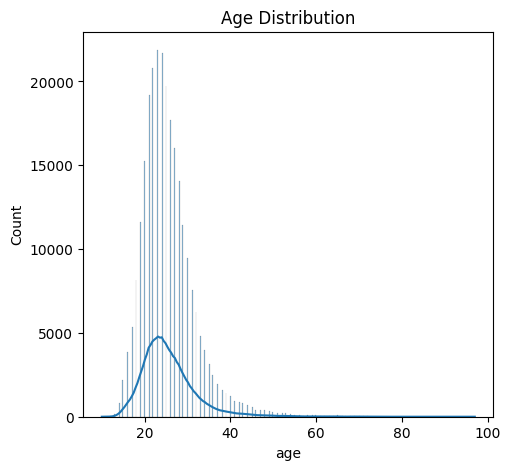

In [3]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['age'].dropna(), kde=True)
plt.title('Age Distribution')


plt.show()

Height Distribution

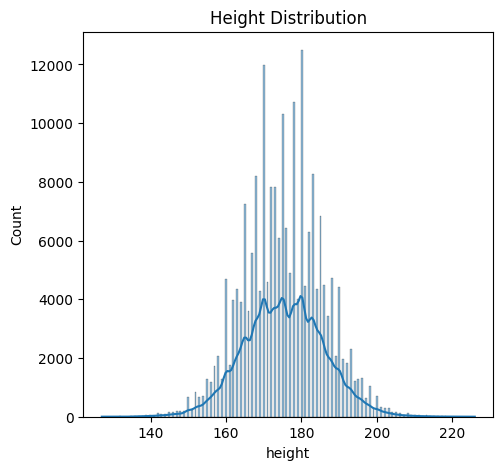

In [4]:
plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 2)
sns.histplot(df['height'].dropna(), kde=True)
plt.title('Height Distribution')
plt.show()

Weight Distribution

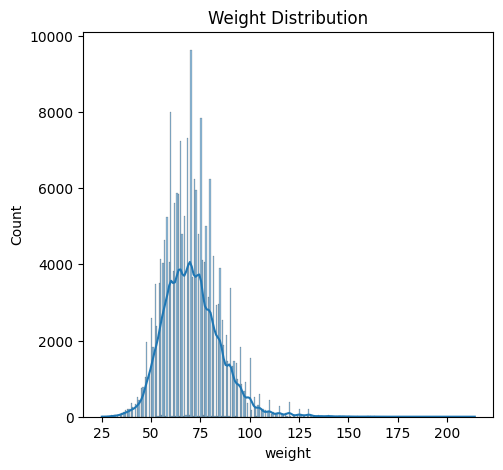

In [5]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 3)
sns.histplot(df['weight'].dropna(), kde=True)
plt.title('Weight Distribution')

plt.show()

Number of medals by country

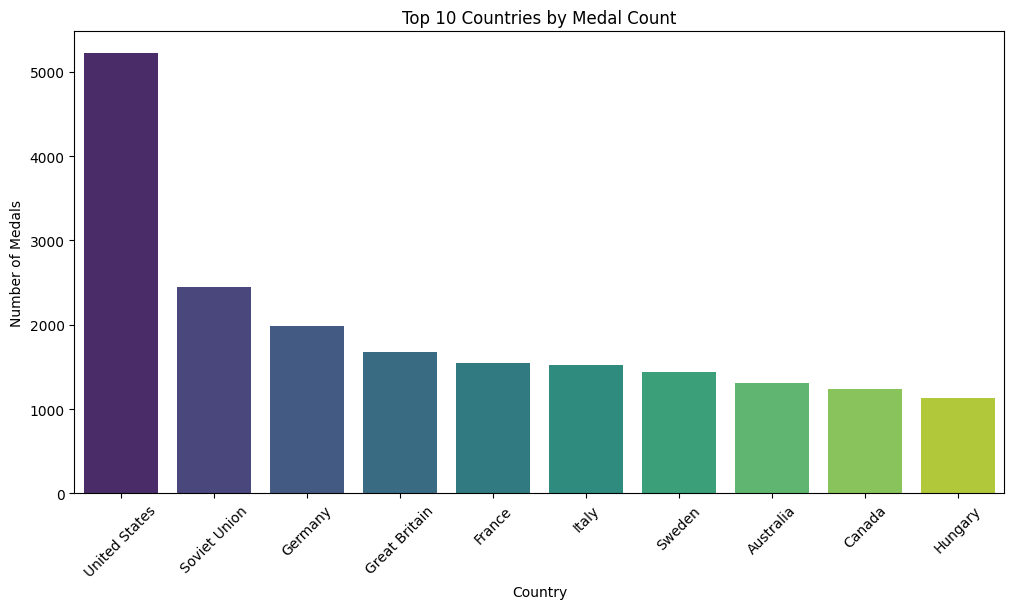

In [8]:
medal_mapping = {'Gold': 3, 'Silver': 2, 'Bronze': 1}
df_medal = df.copy()
df_medal['medal_value'] = df_medal['medal'].map(medal_mapping)


df_medal = df_medal.dropna(subset=['medal_value'])


top_countries = df_medal[df_medal['medal_value'] > 0]['team'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')
plt.title('Top 10 Countries by Medal Count')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.xticks(rotation=45)
plt.show()


## Exploratory Data Analysis



Check for missing values

In [3]:
none_counts = df.isna().sum()
print(none_counts)

id             0
name           0
sex            0
age         9474
height     60171
weight     62875
team           0
noc            0
games          0
year           0
season         0
city           0
sport          0
event          0
medal     231333
dtype: int64


Encoding Medals and Handling Missing Values

In [4]:
df['medal'] = df['medal'].map({'Gold': 1, 'Silver': 1, 'Bronze': 1, np.nan: 0})
df[['age','weight','height']] = df[['age','weight','height']].fillna(method='bfill')


none_counts = df.isna().sum()
print(none_counts)

id        0
name      0
sex       0
age       0
height    0
weight    0
team      0
noc       0
games     0
year      0
season    0
city      0
sport     0
event     0
medal     0
dtype: int64


Correlation Map

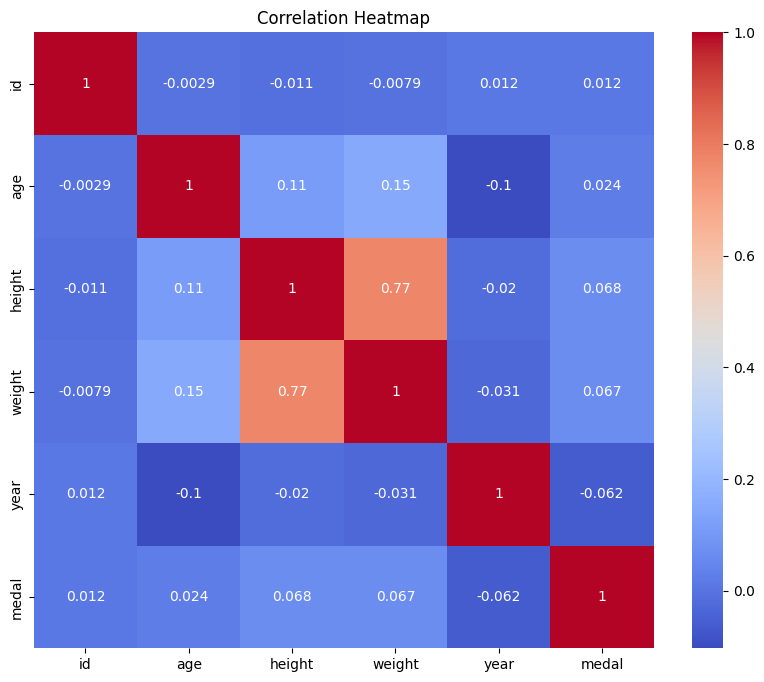

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Handle The `team` column is messy and sometimes contains countries separated by forward slashes or hyphens. Need to remove that completely since noc column gives same information.

In [6]:
df.drop(columns=['team'], inplace=True)

Drop 'sex', and 'sport' columns as 'event' contains detailed info also we will use id to determine which players which, Lastly we remove games since season and year given along with weight and height since we created bmi.

In [8]:
df.drop(columns=['sex', 'sport', 'name', 'games'], inplace=True)
df.head()

,id,age,height,weight,noc,year,season,city,event,medal
0,1,24.0,180.0,80.0,CHN,1992,Summer,Barcelona,Basketball Men's Basketball,0
1,2,23.0,170.0,60.0,CHN,2012,Summer,London,Judo Men's Extra-Lightweight,0
2,3,24.0,185.0,82.0,DEN,1920,Summer,Antwerpen,Football Men's Football,0
3,4,34.0,185.0,82.0,DEN,1900,Summer,Paris,Tug-Of-War Men's Tug-Of-War,1
4,5,21.0,185.0,82.0,NED,1988,Winter,Calgary,Speed Skating Women's 500 metres,0


Encode Remaining Categorical Features

In [9]:
def binary_encode(df, columns, positive_values):
    df = df.copy()
    for column, positive_value in zip(columns, positive_values):
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

df = binary_encode(
    df,
    columns=['season'],
    positive_values=['M', 'Summer']
)

df = onehot_encode(
    df,
    columns=['noc', 'city', 'event'],
    prefixes=['N', 'C', 'E']
)

df    

,id,age,height,weight,year,season,medal,N_AFG,N_AHO,N_ALB,...,"E_Wrestling Men's Super-Heavyweight, Greco-Roman","E_Wrestling Men's Unlimited Class, Greco-Roman","E_Wrestling Men's Welterweight, Freestyle","E_Wrestling Men's Welterweight, Greco-Roman","E_Wrestling Women's Featherweight, Freestyle","E_Wrestling Women's Flyweight, Freestyle","E_Wrestling Women's Heavyweight, Freestyle","E_Wrestling Women's Light-Heavyweight, Freestyle","E_Wrestling Women's Lightweight, Freestyle","E_Wrestling Women's Middleweight, Freestyle"
0,1,24.0,180.0,80.0,1992,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,23.0,170.0,60.0,2012,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,24.0,185.0,82.0,1920,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,34.0,185.0,82.0,1900,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,21.0,185.0,82.0,1988,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,29.0,179.0,89.0,1976,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271112,135570,27.0,176.0,59.0,2014,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271113,135570,27.0,176.0,59.0,2014,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271114,135571,30.0,185.0,96.0,1998,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection

In [10]:
df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)

target = 'medal'

features, train = featurewiz(df, target, corr_limit=0.70, verbose=0)

features

featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
    Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
    Single_Label Binary_Classification problem 
    Loaded train data. Shape = (271116, 1044)
    Single_Label Binary_Classification problem 
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
    Single_Label Binary_Classification problem 
    loading a random sample of 10000 rows into pandas for EDA
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        67 variable(s) to be removed since ID or low-information variables
    	more than 67 variables to be removed; too many to print...
train da

['year',
 'N_USA',
 'N_URS',
 'N_GDR',
 'age',
 'height',
 'N_GER',
 'E_BasketballMensBasketball',
 'E_HockeyMensHockey',
 'E_IceHockeyMensIceHockey',
 'E_FootballMensFootball',
 'N_ITA',
 'N_RUS',
 'N_CAN',
 'N_AUS',
 'N_CHN',
 'N_HUN',
 'E_HandballWomensHandball',
 'E_HockeyWomensHockey',
 'E_IceHockeyWomensIceHockey',
 'E_GymnasticsMensTeamAllAround',
 'E_SwimmingWomens4x100metresFreestyleRelay',
 'N_FRA',
 'N_JPN',
 'E_RugbyMensRugby',
 'E_SwimmingWomens4x100metresMedleyRelay',
 'E_BasketballWomensBasketball',
 'E_GymnasticsWomensTeamAllAround',
 'E_GymnasticsMensTeamAllAroundSwedishSystem',
 'N_ROU',
 'E_SwimmingMens4x200metresFreestyleRelay',
 'E_WaterPoloMensWaterPolo',
 'E_CyclingMensRoadRaceIndividual',
 'N_NED',
 'E_FootballWomensFootball',
 'E_VolleyballWomensVolleyball',
 'E_RowingMensCoxedEights',
 'E_ArtCompetitionsMixedPaintingUnknownEvent',
 'E_GymnasticsMensIndividualAllAround',
 'E_BaseballMensBaseball',
 'E_SwimmingMens4x100metresMedleyRelay',
 'N_CUB',
 'N_EUN',
 'E

## Model Building and Training

split dataset for train and test

In [11]:
X = df[features] 
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape



((244004, 248), (27112, 248), (244004,), (27112,))

### Model Training and Evaluation

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {"Accuracy": accuracy, "F1 Score": f1}
    print(f"{name}: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}")

results
